In [1]:
!pip install ollama
!pip install llama-index==0.10.32
!pip install langchain
!pip install langchain_community
!pip install llama-index-embeddings-ollama


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Using cached llama_index_core-0.10.68.post1-py3-none-any.whl.metadata (2.5 kB)
Using cached llama_index_core-0.10.68.post1-py3-none-any.whl (1.6 MB)
  Attempting uninstall: llama-index-core
    Found existing installation: llama-index-core 0.11.12
    Uninstalling llama-index-core-0.11.12:
      Successfully uninstalled llama-index-core-0.11.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llama-index-embeddings-ollama 0.3.1 requires llama-index-core<0.12.0,>=0.11.0, but you have llama-index-core 0.10.68.post1 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[n

In [2]:
!pip install tensorflow keras scikit-learn



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Concatenate, Input, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from unittest.mock import patch, MagicMock
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import unittest
import numpy as np
import pandas as pd
from langchain_community.embeddings import OllamaEmbeddings


In [21]:
chats_clients = pd.read_csv('data/chats_clients.csv')
chats_clients.shape

(505, 4)

In [22]:
df = chats_clients.copy()

In [23]:
import ollama
model_id = "llama3"

In [24]:
def get_sentence_embedding(prompt):
    return ollama.embeddings(model=model_id, prompt=prompt)['embedding']

In [25]:
df['Pergunta_embedding'] = df['Pergunta'].apply(lambda prompt: get_sentence_embedding(prompt))

In [26]:
df['Pergunta_embedding']

0      [-2.5427753925323486, 0.023201268166303635, 1....
1      [-3.517097234725952, -1.7477946281433105, 2.62...
2      [-3.571645975112915, -2.989140510559082, 3.802...
3      [-0.2691315710544586, 0.423971027135849, -0.90...
4      [-0.8899891972541809, 1.6619807481765747, 2.90...
                             ...                        
500    [-5.187808036804199, -0.8216460347175598, 2.80...
501    [-0.6155379414558411, 0.13867124915122986, 5.0...
502    [-1.8020243644714355, 0.2719815671443939, 1.16...
503    [-1.8270939588546753, 1.7432633638381958, -0.7...
504    [-1.0884336233139038, -3.509136438369751, 1.03...
Name: Pergunta_embedding, Length: 505, dtype: object

In [33]:
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = np.argmax(self.model.predict(val_data), axis=1)
        val_f1 = f1_score(val_labels, val_pred, average='macro')
        recall = recall_score(val_labels, val_pred, average='macro', zero_division=1)
        print(f'Epoch {epoch + 1}: f1-score: {val_f1:.4f} - recall: {recall:.4f}')
        logs['f1_score'] = val_f1
        logs['recall'] = recall

In [34]:
class IntentClassifier:
    def __init__(self, epochs=300, batch_size=16, test_size=0.4, validation_split=0.4, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        # Ajuste para garantir que a entrada seja 3D
        answer_embeddings = answer_embeddings.reshape((answer_embeddings.shape[0], 1, answer_embeddings.shape[1]))

        X_train, X_test, y_train, y_test = train_test_split(answer_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        self.model.add(Dropout(0.4))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.4))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train(self, X_train, X_test, y_train, y_test):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        H = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return H

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

    def evaluate_model(self, H):
      # Obter métricas de precisão e perda do treinamento
      acc = H.history['accuracy']
      val_acc = H.history['val_accuracy']
      loss = H.history['loss']
      val_loss = H.history['val_loss']

      epochs = range(1, len(acc) + 1)

      # Plotar precisão do conjunto
      plt.subplot(2, 2, 3)
      plt.plot(epochs, acc, 'r', label='Precisão do Conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Precisão do Conjunto de Validação')
      plt.title('Precisão do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Precisão')
      plt.legend()

      # Plotar perda do conjunto
      plt.subplot(2, 2, 4)
      plt.plot(epochs, loss, 'r', label='Perda do Conjunto de Treino')
      plt.plot(epochs, val_loss, 'b', label='Perda do Conjunto de Validação')
      plt.title('Perda do Conjunto de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Perda')
      plt.legend()

      plt.tight_layout()
      plt.show()

In [35]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(df)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
H = classifier.train(X_train, X_test, y_train, y_test)

/Users/joaopedroalcaraz/Documents/GitHub/2024-2A-T01-CC11-G03/notebooks/sprint 3/LLM/venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 1, 256)         │     4,326,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,415,410 (16.84 MB)

 Trainable params: 4,415,410 (16.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step p - accuracy: 0.1848 - loss: 2.8
Epoch 1: f1-score: 0.0202 - recall: 0.0556
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.1856 - loss: 2.8223 - val_accuracy: 0.2459 - val_loss: 2.7674 - f1_score: 0.0202 - recall: 0.0556
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/steptep - accuracy: 0.3023 - loss: 2.67
Epoch 2: f1-score: 0.0202 - recall: 0.0556
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2905 - loss: 2.6664 - val_accuracy: 0.2459 - val_loss: 2.6403 - f1_score: 0.0202 - recall: 0.0556
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/steptep - accuracy: 0.2529 - loss: 2.53
Epoch 3: f1-score: 0.0202 - recall: 0.0556
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2526 - loss: 2.5294 - val_accuracy: 0.2459 - val_loss: 2.5645 - f1_score: 0.0202 - recall: 0.0556
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/steptep - accuracy: 0.3278 - loss: 2.30
Epoch 4: f1-score: 0.0482 - recall: 0.0800
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/st

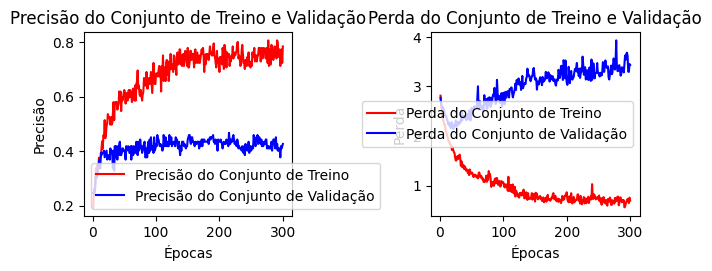

In [36]:
classifier.evaluate_model(H)

In [37]:
y_pred_classes = classifier.predict(X_test)
classifier.generate_report(y_test, y_pred_classes)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
202
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.00      0.00      0.00         1
           2       0.50      0.08      0.13        13
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         3
           6       0.61      0.68      0.64        25
           7       0.77      0.80      0.78        45
           8       0.00      0.00      0.00         1
           9       0.75      0.58      0.65        31
          10       0.38      0.30      0.33        10
          11       0.00      0.00      0.00         5
          12       0.15      0.55      0.24        11
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         3
          16       0.64      0.64      

/Users/joaopedroalcaraz/Documents/GitHub/2024-2A-T01-CC11-G03/notebooks/sprint 3/LLM/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/joaopedroalcaraz/Documents/GitHub/2024-2A-T01-CC11-G03/notebooks/sprint 3/LLM/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/joaopedroalcaraz/Documents/GitHub/2024-2A-T01-CC11-G03/notebooks/sprint 3/LLM/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined

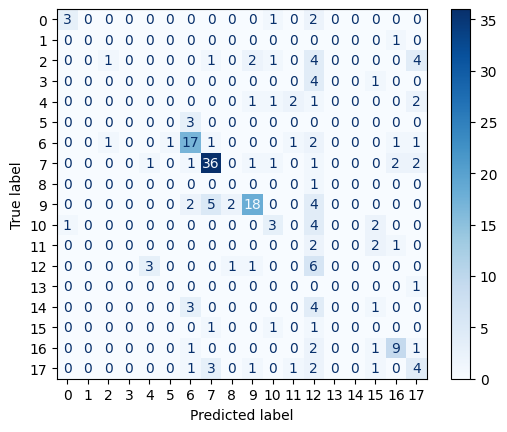

In [38]:
# Calcula a matriz de confusão
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()